### Copyright 2022 Google LLC.

Licensed under the Apache License, Version 2.0 (the "License");

In [1]:
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

### Learning with little mixing

This colab notebook accompanies the following paper:

    Learning with little mixing.
    Ingvar Ziemann and Stephen Tu.
    NeurIPS 2022.
    https://arxiv.org/abs/2206.08269


This notebook reproduces the experiments described in the "Numerical experiments" section. Specifically, we look at the $L^2$ excess risk of learning
from the following generalized linear model (GLM) trajectory process:
$$
  X_{t+1} = \sigma(A^\star X_t) + W_t.
$$
We choose $A^\star$ to have operator (spectral) norm strictly less than one so 
that the covariate process $\{X_t\}$ is ergodic. The labels $Y_t$ are given by
$Y_{t} = X_{t-1}$, which indicates we are performing system identification
to recover the unknown dynamics matrix $A^\star$.
The link function $\sigma(\cdot)$ is the LeakyReLU, and is applied elementwise.

Given the covariates/labels $\{(X_t, Y_t)\}_{t=1}^{T}$, we consider the
empirical risk minimizer:
$$
  \hat{A} \in \operatorname{argmin}_{A}\left\{ \frac{1}{T}\sum_{t=1}^{T} \| \sigma(A X_t) - Y_t \|^2 \right\}. 
$$
The $L^2$ excess risk of an estimate $A$ is:
$$
  L(A) = \frac{1}{T}\mathbb{E}\sum_{t=1}^{T} \| \sigma(A X_t) - \sigma(A^\star X_t) \|^2,
$$
We will compare the ERM's excess risk with the ERM on an 
**independent baseline** dataset $\{(\bar{X}_t, \bar{Y}_t)\}_{t=1}^{T}$, where each $\bar{X}_t$ has
the same distribution as the original $X_t$, but $\bar{X}_t$ is independent
from $\bar{X}_{t'}$ for $t \neq t'$. A descriptive generative model for this
baseline is to sample $T$ independent copies of the process $\{X_t^{(i)}\}_{t=1}^{T}$ for $i \in [T]$,
and set $\bar{X}_t = X_t^{(t)}$. The conditional distribution $\bar{Y}_t \mid \bar{X}_t$ remains the same.


In [ ]:
from typing import Any, Callable, Sequence, Tuple

import enum
import dataclasses
import functools

import numpy as np
import scipy as sp
import jax.numpy as jnp
import jax.scipy as jsp
import jax

import haiku as hk

import itertools as it
import time

import matplotlib.pylab as plt
import seaborn as sns

from jax.config import config as jax_config
jax_config.update('jax_enable_x64', True)

from tqdm import tqdm

In [ ]:
PyTree = Any
# x_{t+1} = f(x_t)
DynamicsFunction = Callable[[jnp.ndarray], jnp.ndarray]

In [ ]:
def rollout(dynamics: DynamicsFunction,
            x0: jnp.ndarray,
            noises: jnp.ndarray) -> jnp.ndarray:
  def scan_fn(x, w):
    next_x = dynamics(x) + w
    return next_x, next_x
  _, xs = jax.lax.scan(scan_fn, x0, noises)
  return xs


@functools.partial(jax.jit, static_argnums=(0, 2, 5))
def random_rollout(dynamics: DynamicsFunction,
                   key: jnp.ndarray,
                   dim: int,
                   init_scale: float,
                   noise_scale: float,
                   horizon: int) -> jnp.ndarray:
  sk1, sk2 = jax.random.split(key)
  x0 = init_scale * jax.random.normal(sk1, shape=(dim,))
  noises = noise_scale * jax.random.normal(sk2, shape=(horizon, dim))
  return rollout(dynamics, x0, noises)


@functools.partial(jax.jit, static_argnums=(0, 2, 5))
def random_coupled_dataset(dynamics: DynamicsFunction,
                           key: jnp.ndarray,
                           dim: int,
                           init_scale: float,
                           noise_scale: float,
                           horizon: int) -> Tuple[jnp.ndarray, jnp.ndarray]:
  traj = random_rollout(
      dynamics, key, dim, init_scale, noise_scale, horizon + 1)
  return traj[:-1], traj[1:]


@functools.partial(jax.jit, static_argnums=(0, 2, 5))
def random_decoupled_dataset(dynamics: DynamicsFunction,
                             key: jnp.ndarray,
                             dim: int,
                             init_scale: float,
                             noise_scale: float,
                             horizon: int) -> Tuple[jnp.ndarray, jnp.ndarray]:
  sks = jax.random.split(key, num=horizon + 1)
  all_trajs = jax.vmap(random_rollout, 
                       in_axes=(None, 0, None, None, None, None))(
      dynamics, sks, dim, init_scale, noise_scale, horizon + 1)
  xs = all_trajs[jnp.arange(horizon), jnp.arange(horizon)]
  ys = all_trajs[jnp.arange(horizon), 1 + jnp.arange(horizon)]
  assert xs.shape == ys.shape
  return xs, ys


def random_dynamics_matrix(key: jnp.ndarray, 
                           rho: float, 
                           dim: int) -> jnp.ndarray:
  assert dim >= 1
  # random orthogonal matrix
  sk1, sk2 = jax.random.split(key)
  W = jax.random.normal(sk1, shape=(dim, dim))
  Q, _ = jnp.linalg.qr(W)
  diag = jnp.array([rho] * (dim // 2) + [rho / 3] * (dim - (dim // 2)))
  return Q @ jnp.diag(diag) @ Q.T

In [ ]:
def test_random_datasets():
  """Some sanity checks."""
  prng = hk.PRNGSequence(jax.random.PRNGKey(89237))
  dim = 5
  true_A = random_dynamics_matrix(next(prng), rho=0.99, dim=dim)
  activation_fn = functools.partial(jax.nn.leaky_relu, negative_slope=0.5)
  def true_dynamics_fn(state: jnp.ndarray) -> jnp.ndarray:
    return activation_fn(true_A @ state)

  xs, ys = random_coupled_dataset(
      true_dynamics_fn,
      next(prng),
      dim,
      init_scale=1.0,
      noise_scale=0.0,
      horizon=10)
  assert jnp.allclose(
      jax.vmap(true_dynamics_fn, in_axes=(0,))(xs), ys)
  
  xs, ys = random_decoupled_dataset(
      true_dynamics_fn,
      next(prng),
      dim,
      init_scale=1.0,
      noise_scale=0.0,
      horizon=10)
  assert jnp.allclose(
      jax.vmap(true_dynamics_fn, in_axes=(0,))(xs), ys)
test_random_datasets()

In [56]:
dim = 25
# seed is fixed for reproducibility
prng = hk.PRNGSequence(jax.random.PRNGKey(7398328))
init_scale = 1.0
noise_scale = 0.1
activation_fn = functools.partial(jax.nn.leaky_relu, negative_slope=0.5)

In [ ]:
@jax.jit
def loss(params: jnp.ndarray, 
         xs: jnp.ndarray,
         ys: jnp.ndarray) -> float:
  assert len(xs.shape) == 2
  assert xs.shape == ys.shape
  return 1/len(xs) * jnp.sum(jnp.square(
      ys - jax.vmap(lambda x: activation_fn(params @ x), in_axes=(0,))(xs)))

In [ ]:
@jax.jit
def sp_loss(flat_params: jnp.ndarray, 
            xs: jnp.ndarray,
            ys: jnp.ndarray) -> float:
  return loss(flat_params.reshape((dim, dim)), xs, ys)

_sp_grad_loss = jax.jit(jax.grad(sp_loss, argnums=0))
def sp_grad_loss(flat_params: np.ndarray, 
                 xs: jnp.ndarray,
                 ys: jnp.ndarray) -> np.ndarray:
  ret = np.array(
      jax.device_get(
          _sp_grad_loss(flat_params.reshape((dim, dim)), xs, ys)).flatten())
  return ret

In [ ]:
@functools.partial(jax.jit, static_argnums=(3, 4))
def excess_risk(true_A: jnp.ndarray, learned_A: jnp.ndarray, key: jnp.ndarray,
                horizon: int, num_evals: int) -> float:

  def true_dynamics_fn(state):
    return activation_fn(true_A @ state)

  test_xs = jax.vmap(
      lambda sk: random_rollout(
          true_dynamics_fn,
          sk,
          dim,
          init_scale=init_scale,
          noise_scale=noise_scale,
          horizon=horizon),
      in_axes=(0,))(
          jax.random.split(key, num=num_evals))

  def score_one_traj(traj):
    return jnp.mean(
        jax.vmap(
            lambda x: jnp.sum(
                jnp.square(
                    activation_fn(true_A @ x) - activation_fn(learned_A @ x))),
            in_axes=(0,))(traj))

  return jnp.mean(jax.vmap(score_one_traj, in_axes=(0,))(test_xs))

In [ ]:
def make_excess_risk_curve(key: jnp.ndarray,
                           true_A: jnp.ndarray,
                           train_xs: jnp.ndarray,
                           train_ys: jnp.ndarray,
                           eval_horizons: Sequence[int]) -> jnp.ndarray:
  assert train_xs.shape == train_ys.shape
  prng = hk.PRNGSequence(key)
  excess_risks = []
  for eval_horizon in tqdm(eval_horizons):
    assert eval_horizon <= len(train_xs)
    train_xs_prefix = train_xs[:eval_horizon]
    train_ys_prefix = train_ys[:eval_horizon]
    res = sp.optimize.minimize(
        functools.partial(sp_loss, xs=train_xs_prefix, ys=train_ys_prefix),
        np.zeros((dim * dim,)),
        method='L-BFGS-B',
        jac=functools.partial(
            sp_grad_loss, xs=train_xs_prefix, ys=train_ys_prefix))
    if not res.success:
      print("ERROR:")
      print(res)
    learned_A = res.x.reshape((dim, dim))
    excess_risks.append(
        excess_risk(true_A, learned_A, next(prng), 
                    eval_horizon, num_evals=1000))
  return jnp.array(excess_risks)

In [ ]:
rhos = [0.9, 0.99]
rho_to_true_As = {}
rho_to_datasets = {}
# number of repeated datasets for error bars
num_train_datasets = 10

def generate_data(fn, dynamics_fn, key, dim, 
                  init_scale, noise_scale, horizon, num_train_datasets):
  all_xs, all_ys = [], []
  prng_seq = hk.PRNGSequence(key)
  # note: this is not vmap-ed since we get OOM errors when the horizon is
  # too long. making it an explicit for loop seems to avoid the OOM issues. 
  for _ in tqdm(range(num_train_datasets)):
    xs, ys = fn(dynamics_fn, next(prng_seq), dim, 
                init_scale, noise_scale, horizon)
    all_xs.append(xs)
    all_ys.append(ys)
  return jnp.array(all_xs), jnp.array(all_ys)

for rho in rhos:
  print(f"generating data for rho={rho}")
  true_A = random_dynamics_matrix(next(prng), rho, dim)
  all_coupled_train_xs, all_coupled_train_ys = generate_data(
      random_coupled_dataset,
      lambda x: activation_fn(true_A @ x),
      next(prng),
      dim,
      init_scale,
      noise_scale,
      5000,
      num_train_datasets)
  all_ind_train_xs, all_ind_train_ys = generate_data(
      random_decoupled_dataset,
      lambda x: activation_fn(true_A @ x),
      next(prng),
      dim,
      init_scale,
      noise_scale,
      5000,
      num_train_datasets)
  rho_to_true_As[rho] = true_A
  rho_to_datasets[rho] = {
      'coupled': (all_coupled_train_xs, all_coupled_train_ys),
      'ind': (all_ind_train_xs, all_ind_train_ys),
  }

In [66]:
short_horizons = [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]
extra_horizons = [2000, 3000, 4000, 5000]
long_horizons = [short_horizons[-1]] + extra_horizons
eval_horizons = short_horizons + extra_horizons

In [ ]:
rho_to_risk_curves = {}

for rho in rhos:
  print(f"generating risk curves for rho={rho}")
  mixing_risk_curves = [] 
  for coupled_train_xs, coupled_train_ys in zip(
      *rho_to_datasets[rho]['coupled']):
    mixing_risk_curves.append(
        make_excess_risk_curve(next(prng), 
                               rho_to_true_As[rho],
                               coupled_train_xs, 
                               coupled_train_ys, 
                               eval_horizons))
  mixing_risk_curves = np.array(mixing_risk_curves)
  ind_risk_curves = [] 
  for ind_train_xs, ind_train_ys in zip(
      *rho_to_datasets[rho]['ind']):
    ind_risk_curves.append(
        make_excess_risk_curve(next(prng), 
                               rho_to_true_As[rho],
                               ind_train_xs, 
                               ind_train_ys, 
                               eval_horizons))
  ind_risk_curves = np.array(ind_risk_curves)
  rho_to_risk_curves[rho] = {
      'coupled': mixing_risk_curves,
      'ind': ind_risk_curves,
  }

In [69]:
labelsize = 14
legendsize = 12

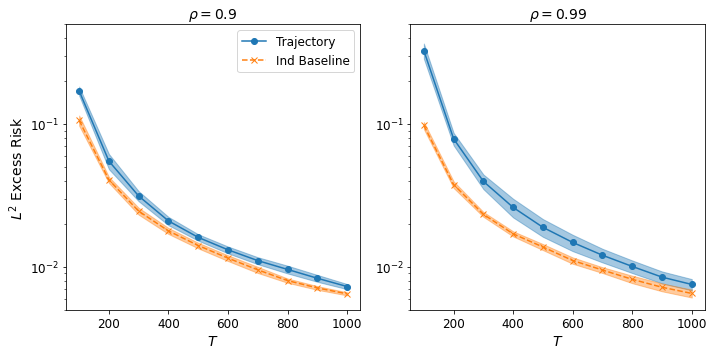

In [73]:
plt.figure(figsize=(10, 5))
plt.rc('xtick', labelsize=legendsize)
plt.rc('ytick', labelsize=legendsize)

colors = sns.color_palette(n_colors=2)

for idx, rho in enumerate(rhos):
  mixing_risk_curves = rho_to_risk_curves[rho]['coupled']
  ind_risk_curves = rho_to_risk_curves[rho]['ind']
  mixing_risk_curves = mixing_risk_curves[:, :len(short_horizons)]
  ind_risk_curves = ind_risk_curves[:, :len(short_horizons)]

  mixing_risk_means = np.mean(mixing_risk_curves, axis=0)
  mixing_risk_stds = np.std(mixing_risk_curves, axis=0)
  ind_risk_means = np.mean(ind_risk_curves, axis=0)
  ind_risk_stds = np.std(ind_risk_curves, axis=0)

  plt.subplot(1, len(rhos), idx + 1)

  plt.semilogy(short_horizons, mixing_risk_means, '-o', color=colors[0])
  plt.fill_between(
      short_horizons,
      mixing_risk_means - mixing_risk_stds,
      mixing_risk_means + mixing_risk_stds,
      color=colors[0],
      alpha=0.4)

  plt.semilogy(short_horizons, ind_risk_means, '--x', color=colors[1])
  plt.fill_between(
      short_horizons,
      ind_risk_means - ind_risk_stds,
      ind_risk_means + ind_risk_stds,
      color=colors[1],
      alpha=0.4)

  plt.ylim(5e-3, 5e-1)

  plt.xlabel(r'$T$', fontsize=labelsize)
  if idx == 0:
    plt.ylabel(r'$L^2$ Excess Risk', fontsize=labelsize)
    plt.legend(('Trajectory', 'Ind Baseline'), fontsize=legendsize)
  plt.title(r'$\rho={}$'.format(rho), fontsize=labelsize)

plt.tight_layout()
plt.savefig('glm_little_mixing_risks.pdf')

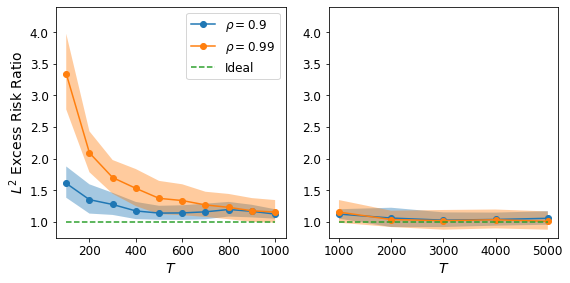

In [76]:
plt.figure(figsize=(8, 4))
plt.rc('xtick', labelsize=legendsize)
plt.rc('ytick', labelsize=legendsize)

colors = sns.color_palette(n_colors=len(rhos) + 1)

plt.subplot(1, 2, 1)

for rho, color in zip(rhos, colors):

  mixing_risk_curves = rho_to_risk_curves[rho]['coupled']
  ind_risk_curves = rho_to_risk_curves[rho]['ind']
  mixing_risk_curves = mixing_risk_curves[:, :len(short_horizons)]
  ind_risk_curves = ind_risk_curves[:, :len(short_horizons)]

  mixing_risk_means = np.mean(mixing_risk_curves, axis=0)
  mixing_risk_stds = np.std(mixing_risk_curves, axis=0)
  ind_risk_means = np.mean(ind_risk_curves, axis=0)
  ind_risk_stds = np.std(ind_risk_curves, axis=0)

  plt.plot(
      short_horizons, mixing_risk_means / ind_risk_means, '-o', color=color)
  plt.fill_between(
      short_horizons,
      (mixing_risk_means - mixing_risk_stds) / (ind_risk_means + ind_risk_stds),
      (mixing_risk_means + mixing_risk_stds) / (ind_risk_means - ind_risk_stds),
      alpha=0.4)

plt.plot(short_horizons, np.ones_like(short_horizons), '--', color=colors[-1])

plt.xlabel(r'$T$', fontsize=labelsize)
plt.ylabel(r'$L^2$ Excess Risk Ratio', fontsize=labelsize)
plt.legend(
    [r'$\rho={}$'.format(rho) for rho in rhos] + ['Ideal'], fontsize=legendsize)
plt.ylim((0.75, 4.4))

plt.subplot(1, 2, 2)

for rho, color in zip(rhos, colors):

  mixing_risk_curves = rho_to_risk_curves[rho]['coupled']
  ind_risk_curves = rho_to_risk_curves[rho]['ind']
  mixing_risk_curves = mixing_risk_curves[:, len(short_horizons) - 1:]
  ind_risk_curves = ind_risk_curves[:, len(short_horizons) - 1:]

  mixing_risk_means = np.mean(mixing_risk_curves, axis=0)
  mixing_risk_stds = np.std(mixing_risk_curves, axis=0)
  ind_risk_means = np.mean(ind_risk_curves, axis=0)
  ind_risk_stds = np.std(ind_risk_curves, axis=0)

  plt.plot(long_horizons, mixing_risk_means / ind_risk_means, '-o', color=color)
  plt.fill_between(
      long_horizons,
      (mixing_risk_means - mixing_risk_stds) / (ind_risk_means + ind_risk_stds),
      (mixing_risk_means + mixing_risk_stds) / (ind_risk_means - ind_risk_stds),
      alpha=0.4)

plt.plot(long_horizons, np.ones_like(long_horizons), '--', color=colors[-1])
plt.xlabel(r'$T$', fontsize=labelsize)
plt.ylim((0.75, 4.4))

plt.tight_layout()
plt.savefig('glm_little_mixing_ratio_long.pdf')